## Explaination of flight probability function (h_flight_prob in code)

### Setup - $f(t)$

To begin with, we have two functions. The first is a **probability density function** (probability mass function in the code implementation, since time must be discretized) which gives the probability of flying at any given time of day assuming that the probabiilty of taking a flight sometime during the day is 1. This function is called f_time_prob in the code, $f(t)$ here in text. In this example we will suppose it looks like this:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

Nmin = 1440 # 1440 minutes in a day!

def f_time_prob(n=1440, a1=7,b1=1.5,a2=19,b2=1.5):
    """Returns probability mass function of flying based on time at n equally
    spaced times.
    
    Arguments:
        - n -- number of wind data points per day available
        - a1 -- time of morning at which to return 0.5
        - b1 -- steepness of morning curve (larger numbers = steeper)
        - a2 -- time of afternoon at which to return 0.5
        - b2 -- steepness of afternoon curve (larger numbers = steeper)
        
    Returns:
        - A probability mass function for flying in each of n intervals
            during the day"""
    
    # time is in hours, and denotes start time of flight.
    
    # wind was recorded starting after the first 30 min, so exclude midnight
    #   at the start, include it at the end.
    t_tild = np.linspace(0+24./n,24,n) #divide 24 hours into n equally spaced times
    # Calculate the likelihood of flight at each time of day, giving a number
    #   between 0 and 1. Combination of two logistic functions.
    likelihood = 1.0 / (1. + np.exp(-b1 * (t_tild - a1))) - \
                    1.0 / (1. + np.exp(-b2 * (t_tild - a2)))
    # Scale the likelihood into a proper probability mass function, and return
    return likelihood/likelihood.sum()

f_func = f_time_prob()

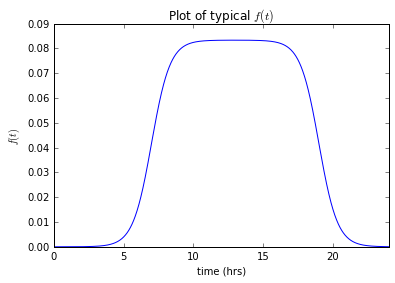

In [2]:
time_vec = np.linspace(0+24./Nmin,24,Nmin) # time elapsed in hours
plt.figure()
plt.plot(time_vec,f_func*60) # multiplying by 60 here so it looks like the probability density function
                             #    would, matching the x-axis units of hours. In code, f_func is a
                             #    probability mass function - f_func.sum() = 1.
plt.xlabel('time (hrs)')
plt.ylabel(r'$f(t)$')
plt.title(r'Plot of typical $f(t)$')
plt.axis([0,24,0,0.09])
plt.show()

### Setup - $g(t,w(t))$

The second function is not a probability density, but instead is a scaling function that takes on values between 0 and 1 and is supposed to represent the probability of flight at any time $t$ given wind conditions $w(t)$. It may look something like this:

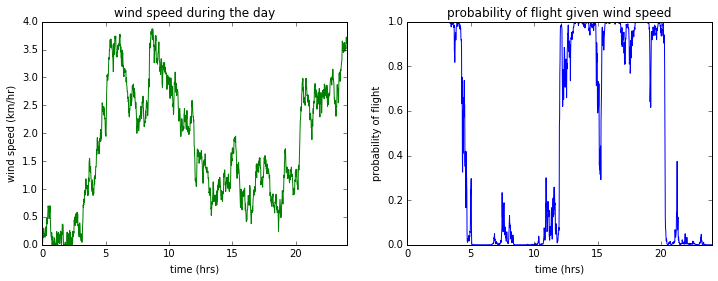

In [3]:
def g_wind_prob(windr, aw=1.8,bw=6):
    """Returns probability of flying under given wind conditions.
    If the wind has no effect on flight probability, returns 1.
    Otherwise, scales down from 1 to 0 as wind speed increases.
    
    Arguments:
        - windr -- wind speed
        - aw -- wind speed at which flight prob. is scaled by 0.5
        - bw -- steepness at which scaling changes (larger numbers = steeper)"""
    return 1.0 / (1. + np.exp(bw * (windr - aw)))

# Generate some "wind"
np.random.seed(100)
sigma = 0.1
wind = np.zeros(Nmin)

S = sigma*np.random.randn(Nmin)
wind[0] = np.max((0,S[0]))
for ii in range(1,Nmin):
    wind[ii] = np.max((0,wind[ii-1] + S[ii]))
    
g_func = g_wind_prob(windr=wind)
    
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(time_vec,wind,'g')
plt.xlabel('time (hrs)')
plt.ylabel('wind speed (km/hr)')
plt.title('wind speed during the day')
plt.axis([0,24,0,4])
plt.subplot(122)
plt.plot(time_vec,g_func)
plt.xlabel('time (hrs)')
plt.ylabel('probability of flight')
plt.title('probability of flight given wind speed')
plt.axis([0,24,0,1])
plt.show()

### $g(t,w(t))$ applied to $f(t)$

To scale $f(t)$ by $g(t,w(t))$, we simply multiply. The result, $f_g(t,w(t))$ is no longer a probability density function (mass function in the descretized code) because it does not integrate/sum to one, but we can simply consider the difference as the probability that no flight is taken during the day.

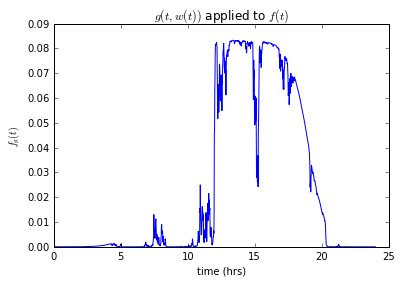

In [4]:
plt.figure()
plt.plot(time_vec,f_func*60*g_func)
plt.xlabel('time (hrs)')
plt.ylabel(r'$f_g(t)$')
plt.title(r'$g(t,w(t))$ applied to $f(t)$')
plt.show()

### Waiting for a good time to fly

The problem with this approach is that in essence, it only gives insects one shot at taking a flight during the day. It's as if each flyer says picks a time in advance according to $f(t)$ and then, once the wind condition at the moment is known, actually takes that flight or not with probability $g(t,w(t))$. If no flight is taken at that moment, none is taken during the day. Modeling flight in this way will most likely underestimate the number of fliers per day significantly.

What we want to do instead is allow those insects who were unable to take a flight early in the day the chance to take a flight later. We will do this in a weighted way - distributing the probability over the rest of the day but not forcing a flight if the day is already late. Another way of looking at it: as the day wears on, there should be less chance that an insect which didn't take a flight earlier will take one now, simply because there is less time left in the day and smaller scale activity may have been taking place earlier. In doing this calculation, we should take into account $f(t)$ and $g(t)$, so that insects are not taking flights at times they normally wouldn't anyway.

The model I have come up for is
$$h(t) = f_g(t) + \frac{f(t)g(t)}{f_{max}\cdot t}\int_0^t (1-[\int_0^sf(r)\ dr]^{\alpha})(f(s) - f_g(s))\ ds$$
This calculation is basically a weighted average (where the weight is the cumulative distribution function of $f(t)$), which is then scaled by $g(t)$ and the maximum of $f$. The result is then added back to $f_g(t)$.

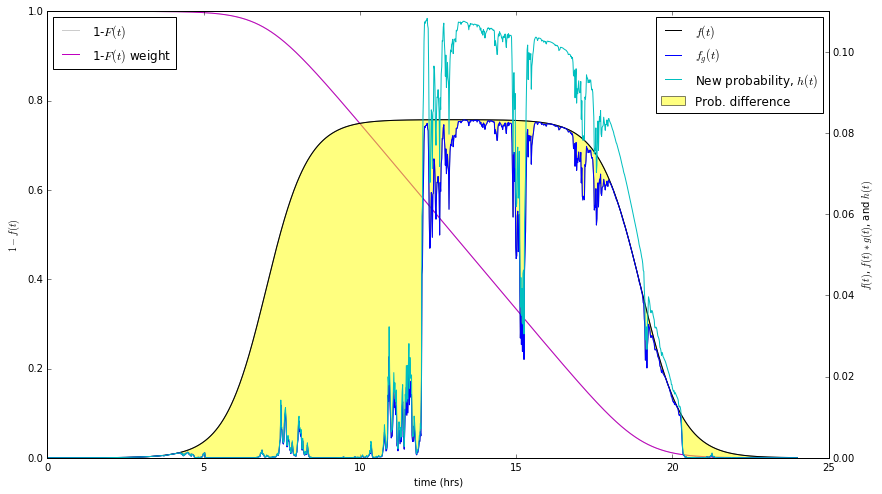

Total probability of flying during the day: 0.6952082556187194 vs. 0.5536600804506806 before.



In [7]:
# change this value, 0 < cur_s <= 24, to see calculation at different stages.
cur_s = 24


alpha_pow = 1
int_1_minus_f = 1 - np.cumsum(f_func)**alpha_pow


min_vec = np.linspace(1,24*60,24*60)
integral_avg = f_func*g_func/min_vec/np.amax(f_func)*np.cumsum((1-np.cumsum(f_func)**alpha_pow)*(f_func-f_func*g_func))


s_vec = np.linspace(0+24./(cur_s*60),cur_s,cur_s*60)
h_func = f_func*g_func + integral_avg

fig, ax1 = plt.subplots(figsize=(14,8))
ax1.plot(time_vec,int_1_minus_f,'0.80',label=r'1-$F(t)$')
ax1.set_xlabel('time (hrs)')
ax1.set_ylabel(r'$1-f(t)$')
ax1.set_ylim(0,1)
ax1.hold(True)
ax1.plot(s_vec,int_1_minus_f[:s_vec.size],'m',label=r'1-$F(t)$ weight')
ax1.hold(False)
ax1.legend(loc='upper left')
    
ax2 = ax1.twinx()
ax2.plot(time_vec,f_func*60,'k',label=r'$f(t)$')
ax2.hold(True)
ax2.plot(time_vec,f_func*g_func*60,color='b',label=r'$f_g(t)$')
ax2.fill_between(s_vec,f_func[:s_vec.size]*g_func[:s_vec.size]*60,f_func[:s_vec.size]*60,
                facecolor='yellow',alpha=0.5,label='Prob. difference')
ax2.plot(s_vec,h_func[:s_vec.size]*60,color='c',label=r'New probability, $h(t)$')
ax2.hold(False)
ax2.set_ylim(0,0.11)
# make sure the y-axis label and tick labels match the line color
ax2.set_ylabel(r'$f(t)$, $f(t)*g(t)$, and $h(t)$')
# for t2 in ax2.get_yticklabels():
#     t2.set_color('b')
ax2.legend(loc='upper right')
plt.show()

print('Total probability of flying during the day: {0} vs. {1} before.\n'.format(h_func.sum(),(f_func*g_func).sum()))